# Day 16

In [1]:
%cd ..

from inspect import cleandoc
from matplotlib import pyplot
import ipytest
ipytest.autoconfig()

/home/vagrant/Development/advent-of-code-2022/python


In [2]:
example = cleandoc("""
    Valve AA has flow rate=0; tunnels lead to valves DD, II, BB
    Valve BB has flow rate=13; tunnels lead to valves CC, AA
    Valve CC has flow rate=2; tunnels lead to valves DD, BB
    Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE
    Valve EE has flow rate=3; tunnels lead to valves FF, DD
    Valve FF has flow rate=0; tunnels lead to valves EE, GG
    Valve GG has flow rate=0; tunnels lead to valves FF, HH
    Valve HH has flow rate=22; tunnel leads to valve GG
    Valve II has flow rate=0; tunnels lead to valves AA, JJ
    Valve JJ has flow rate=21; tunnel leads to valve II
    """)

In [3]:
from aocd import get_data
data = get_data(year=2022, day=16)

In [4]:
from collections import defaultdict
from dataclasses import dataclass
from functools import cached_property
from parsec import digit, eof, generate, letter, many1, sepBy, string
from igraph import Graph, plot, layout
from typing import Self

@dataclass
class Valve:
    name: str
    flow_rate: int
    tunnels: list[str]

@dataclass
class CaveScan:
    valves: dict[str, Valve]
    
    @classmethod
    def parse(cls, text: str) -> Self:
        return (cave_scan << eof()).parse(text)
    
    @cached_property
    def useful_valves(self) -> frozenset[str]:
        return frozenset(name for name, valve in self.valves.items() if valve.flow_rate)
    
    @cached_property
    def distances(self) -> dict[str, dict[str]]:
        return {
            u: dict(zip(self.valves, ds))
            for u, ds in zip(self.valves, self.graph.distances(self.valves, self.valves))
        }
        
    @cached_property
    def graph(self) -> Graph:
        result = Graph()
        vertices = list(self.valves)
        result.add_vertices(len(self.valves), attributes={"name": vertices, "label": vertices})
        result.add_edges([
            (valve.name, tunnel)
            for valve in self.valves.values()
            for tunnel in valve.tunnels
            if valve.name < tunnel
        ])
        return result
    
    def max_flows_for_open_valves(self, time: int) -> dict[frozenset[str], int]:
        result = defaultdict(int)

        def visit(u, time, visited, total):
            result[visited] = max(result[visited], total)

            for v in self.useful_valves - visited:
                v_time = time - 1 - self.distances[u][v]
                if v_time < 0:
                    continue
                else:
                    visit(v, v_time, visited | {v}, total + v_time * self.valves[v].flow_rate)

        visit("AA", time, frozenset(), 0)

        return result
    
    def solve1(self) -> int:
        return max(self.max_flows_for_open_valves(30).values())
    
    def solve2(self) -> int:
        max_flows_for_open_valves = self.max_flows_for_open_valves(26)
        
        return max(
            me_pressure + elephant_pressure
            for me_visited, me_pressure in max_flows_for_open_valves.items()
            for elephant_visited, elephant_pressure in max_flows_for_open_valves.items()
            if me_visited.isdisjoint(elephant_visited)
        )

valve_name = many1(letter()).parsecmap(lambda ls: "".join(ls))

@generate
def valve():
    yield string("Valve ")
    name = yield valve_name
    yield string(" has flow rate=")
    flow_rate = yield many1(digit()).parsecmap(lambda ds: int("".join(ds)))
    yield string("; tunnels lead to valves ") ^ string("; tunnel leads to valve ")
    tunnels = yield sepBy(valve_name, string(", "))
    
    return Valve(name, flow_rate, tunnels)

cave_scan = sepBy(valve, string("\n")).parsecmap(lambda valves: CaveScan({valve.name: valve for valve in valves}))

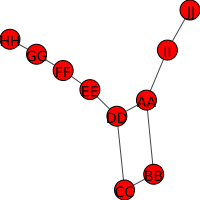

In [5]:
example_scan = CaveScan.parse(example)
plot(example_scan.graph, bbox=(200, 200), margin=10)

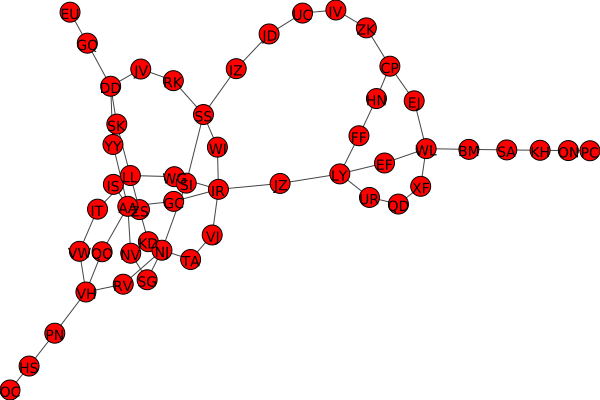

In [6]:
data_scan = CaveScan.parse(data)
data_graph = data_scan.graph
plot(data_graph, bbox=(600, 400), margin=10, layout=data_graph.layout("fr"))

## Part 1

In [7]:
example_scan.solve1()

1651

In [8]:
data_scan.solve1()

2056

## Part 2

In [9]:
example_scan.solve2()

1707

In [10]:
data_scan.solve2()

2513